<strong><b><font size="5">Data Science Academy</font></b></strong>

<strong><b><font size="5">Análise Estatística e Modelagem Preditiva de Séries Temporais - Em Python</font></b></strong>

<strong><b><font size="5">Aula 23</font></b></strong>

<strong><b><font size="4">Otimizando o Modelo de IA Para Previsão da Média Mensal de Vendas com Stacked LSTM</font></b></strong>

Todas as aulas deste curso podem ser encontradas na timeline da Comunidade em nosso portal: www.datascienceacademy.com.br/social

Na aula anterior criamos nosso primeiro modelo de Deep Learning para a Previsão da Média Mensal de Vendas. Agora vamos trabalhar na otimização do modelo e começaremos com um modelo Stacked LSTM.

**Deep Learning - Modelo Stacked LSTM**

O Modelo Stacked LSTM nada mais é do que um Modelo com mais de uma camada LSTM. A camada LSTM é o diferencial do modelo e adicionando mais uma camada esperamos aumentar o poder de acurácia do modelo final.

Nesta aula vamos discutir ainda como calcular o número de neurônios em cada camada.

Esta aula considera algu conhecimento em Deep Learning e esse conhecimento pode ser obtido no material gratuito fornecido pela DSA, o <a href="http://www.deeplearningbook.com.br/">Deep Learning Book</a>. Lá você encontra alguns capítulos inteiros dedicados às LSTMs. Recomendamos a leitura antes de prosseguir nesta aula.

**No Google Colab, altere seu Runtime para executar o treinamento usando GPU**.

Vamos ao trabalho.

### Carregando os Pacotes Usados Neste Jupyter Notebook

In [0]:
# Para atualizar um pacote, execute o comando abaixo no terminal ou prompt de comando:
# pip install -U nome_pacote

# Para instalar a versão exata de um pacote, execute o comando abaixo no terminal ou prompt de comando:
# pip install nome_pacote==versão_desejada

# Depois de instalar ou atualizar o pacote, reinicie o jupyter notebook, se necessário.

In [0]:
# Instala o pacote watermark. 
# Esse pacote é usado para gravar as versões de outros pacotes usados neste jupyter notebook.
!pip install -q -U watermark

In [0]:
# É preciso atualizar o Statsmodels
!pip install -q -U statsmodels

     |████████████████████████████████| 8.7MB 5.9MB/s 


In [0]:
# As novas versões do Pandas e Matplotlib trazem diversas mensagens de aviso ao desenvolvedor. Vamos desativar isso.
import sys
import warnings
import matplotlib.cbook
if not sys.warnoptions:
    warnings.simplefilter("ignore")
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.filterwarnings("ignore", category=FutureWarning)
warnings.filterwarnings("ignore", category=matplotlib.cbook.mplDeprecation)

# Imports para manipulação de dados
import numpy as np
import pandas as pd
import itertools
from pandas import Series
from pandas.tseries.offsets import DateOffset

# Imports para visualização de dados
import matplotlib.pyplot as plt
import matplotlib as m
import seaborn as sns

# Imports para modelagem preditiva
import sklearn
import keras
from sklearn.preprocessing import MinMaxScaler
from keras.preprocessing.sequence import TimeseriesGenerator
from keras.models import Sequential
from keras.layers.core import Dense, Activation
from keras.layers import LSTM
from keras.layers import Dropout
from keras import optimizers
import statsmodels
import statsmodels.api as sm
import statsmodels.tsa.api as smt
import statsmodels.stats as sms
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller


# Imports para formatação dos gráficos
m.rcParams['axes.labelsize'] = 14
m.rcParams['xtick.labelsize'] = 12
m.rcParams['ytick.labelsize'] = 12
m.rcParams['text.color'] = 'k'
from matplotlib.pylab import rcParams 
rcParams['figure.figsize'] = 15,7
matplotlib.style.use('ggplot')
%matplotlib inline

Using TensorFlow backend.


In [0]:
# Versões dos pacotes usados neste jupyter notebook
%reload_ext watermark
%watermark -a "Data Science Academy" --iversions

sklearn         0.22.2.post1
statsmodels     0.11.1
numpy           1.18.3
seaborn         0.10.0
pandas          1.0.3
matplotlib      3.2.1
keras           2.3.1
statsmodels.api 0.11.1
Data Science Academy


## Definição do Problema de Negócio

A HappyMoonVC é uma Venture Capital (VC).

Além do investimento no GoInRail (descrito nas aulas anteriores), a HappyMoonVC está analisando um outro negócio. Uma rede de varejo que poderá fornecer produtos para os clientes do GoInRail (drone elétrico para transporte de passageiros). 

Um monitor touch-screen dentro do GoInRail permitiria que o cliente fizesse a compra de produtos enquanto faz a viagem, com a opção de pegar o produto na estação que for descer ou então receber direto na residência (se acha que isso é futurista demais, saiba que já existe no metrô do Japão).

Para decidir se o investimento vale a pena, a HappyMoonVC precisa prever o volume de vendas.  

Esse é nosso trabalho.

## Conjunto de Dados

Usaremos conjuntos de dados que está disponível publicamente no site do Tableau e que representa as vendas históricas da empresa na qual a HappyMoonVC pretende investir. Aqui o link do dataset (que está sendo fornecido para você):

https://community.tableau.com/docs/DOC-1236

De todos os dados disponíveis, nosso interesse é na categoria de produtos de tecnologia.

In [0]:
# Carrega os dados
dados = pd.read_csv('https://raw.githubusercontent.com/dsacademybr/Datasets/master/dataset6.csv')

In [0]:
# Shape
dados.shape

(9994, 21)

In [0]:
# Colunas
dados.columns

Index(['Row ID', 'Order ID', 'Order Date', 'Ship Date', 'Ship Mode',
       'Customer ID', 'Customer Name', 'Segment', 'Country', 'City', 'State',
       'Postal Code', 'Region', 'Product ID', 'Category', 'Sub-Category',
       'Product Name', 'Sales', 'Quantity', 'Discount', 'Profit'],
      dtype='object')

### Análise Exploratória

In [0]:
# Visualizando os dados
dados.head(3)

,Row ID,Order ID,Order Date,Ship Date,Ship Mode,Customer ID,Customer Name,Segment,Country,City,State,Postal Code,Region,Product ID,Category,Sub-Category,Product Name,Sales,Quantity,Discount,Profit
0,1,CA-2016-152156,2016-11-08,2016-11-11,Second Class,CG-12520,Claire Gute,Consumer,United States,Henderson,Kentucky,42420,South,FUR-BO-10001798,Furniture,Bookcases,Bush Somerset Collection Bookcase,261.96,2,0.0,41.9136
1,2,CA-2016-152156,2016-11-08,2016-11-11,Second Class,CG-12520,Claire Gute,Consumer,United States,Henderson,Kentucky,42420,South,FUR-CH-10000454,Furniture,Chairs,"Hon Deluxe Fabric Upholstered Stacking Chairs,...",731.94,3,0.0,219.5820
2,3,CA-2016-138688,2016-06-12,2016-06-16,Second Class,DV-13045,Darrin Van Huff,Corporate,United States,Los Angeles,California,90036,West,OFF-LA-10000240,Office Supplies,Labels,Self-Adhesive Address Labels for Typewriters b...,14.62,2,0.0,6.8714


In [0]:
# Resumo estatístico
dados.describe()

,Row ID,Postal Code,Sales,Quantity,Discount,Profit
count,9994.000000,9994.000000,9994.000000,9994.000000,9994.000000,9994.000000
mean,4997.500000,55190.379428,229.858001,3.789574,0.156203,28.656896
std,2885.163629,32063.693350,623.245101,2.225110,0.206452,234.260108
min,1.000000,1040.000000,0.444000,1.000000,0.000000,-6599.978000
25%,2499.250000,23223.000000,17.280000,2.000000,0.000000,1.728750
50%,4997.500000,56430.500000,54.490000,3.000000,0.200000,8.666500
75%,7495.750000,90008.000000,209.940000,5.000000,0.200000,29.364000
max,9994.000000,99301.000000,22638.480000,14.000000,0.800000,8399.976000


In [0]:
# Checando valores missing - não temos valores missing no dataset
dados.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9994 entries, 0 to 9993
Data columns (total 21 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Row ID         9994 non-null   int64  
 1   Order ID       9994 non-null   object 
 2   Order Date     9994 non-null   object 
 3   Ship Date      9994 non-null   object 
 4   Ship Mode      9994 non-null   object 
 5   Customer ID    9994 non-null   object 
 6   Customer Name  9994 non-null   object 
 7   Segment        9994 non-null   object 
 8   Country        9994 non-null   object 
 9   City           9994 non-null   object 
 10  State          9994 non-null   object 
 11  Postal Code    9994 non-null   int64  
 12  Region         9994 non-null   object 
 13  Product ID     9994 non-null   object 
 14  Category       9994 non-null   object 
 15  Sub-Category   9994 non-null   object 
 16  Product Name   9994 non-null   object 
 17  Sales          9994 non-null   float64
 18  Quantity

In [0]:
# Ajustando o nome das colunas para que todas fiquem com letras minúsculas
dados.columns = map(str.lower, dados.columns)

In [0]:
# Vamos substituir os espaços e traços nos nomes das colunas por '_'
dados.columns = dados.columns.str.replace(" ", "_")
dados.columns = dados.columns.str.replace("-", "_")

In [0]:
# Conferindo
dados.columns

Index(['row_id', 'order_id', 'order_date', 'ship_date', 'ship_mode',
       'customer_id', 'customer_name', 'segment', 'country', 'city', 'state',
       'postal_code', 'region', 'product_id', 'category', 'sub_category',
       'product_name', 'sales', 'quantity', 'discount', 'profit'],
      dtype='object')

Vamos separar os dados por categoria (Móveis, Tecnologia, Material de escritório).

In [0]:
# Separando os dados por categoria
df_tecnologia = dados.loc[dados['category'] == 'Technology']
df_moveis = dados.loc[dados['category'] == 'Furniture']
df_office = dados.loc[dados['category'] == 'Office Supplies']

Agora vamos preparar as séries temporais.

In [0]:
# Agregando as vendas pela data do pedido
ts_tecnologia = df_tecnologia.groupby('order_date')['sales'].sum().reset_index()
ts_moveis = df_moveis.groupby('order_date')['sales'].sum().reset_index()
ts_office = df_office.groupby('order_date')['sales'].sum().reset_index()

Acesse o <a href="http://datascienceacademy.com.br/blog/">Blog da DSA</a> e fique por dentro das novidades em Data Science, Big Data, IA, RPA, Blockchain e mercado de trabalho.

In [0]:
# Como está ficando o nosso dataset de interesse?
ts_tecnologia

,order_date,sales
0,2014-01-06,1147.940
1,2014-01-09,31.200
2,2014-01-13,646.740
3,2014-01-15,149.950
4,2014-01-16,124.200
...,...,...
819,2017-12-25,401.208
820,2017-12-27,164.388
821,2017-12-28,14.850
822,2017-12-29,302.376


Vamos mover a data para o índice e assim criar a série temporal.

In [0]:
# Colocando a data como índice
ts_tecnologia = ts_tecnologia.set_index('order_date')

In [0]:
# Visualizando a série
ts_tecnologia

,sales
order_date,
2014-01-06,1147.940
2014-01-09,31.200
2014-01-13,646.740
2014-01-15,149.950
2014-01-16,124.200
...,...
2017-12-25,401.208
2017-12-27,164.388
2017-12-28,14.850


Agora podemos conferir a performance de vendas ao longo do tempo.

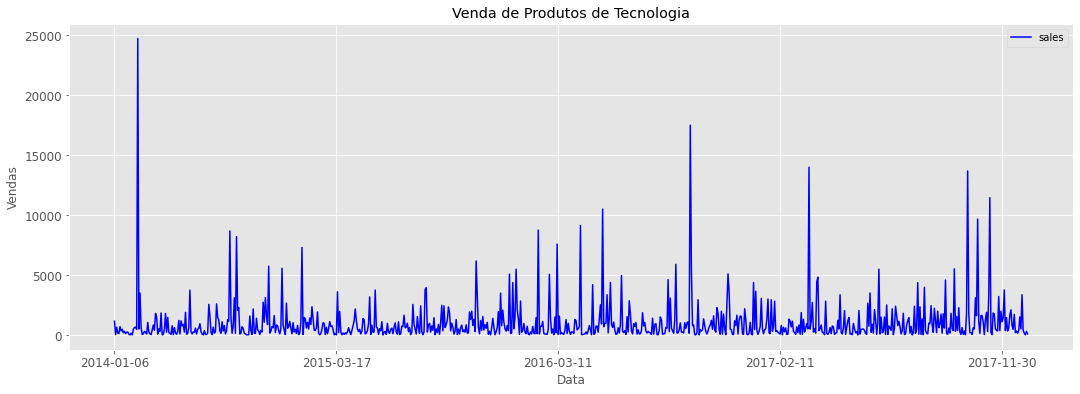

In [0]:
# Venda de Produtos de Tecnologia
vendas_tecnologia = ts_tecnologia[['sales']]
ax = vendas_tecnologia.plot(color = 'b', figsize = (18,6))
plt.xlabel("Data")
plt.ylabel('Vendas')
plt.title("Venda de Produtos de Tecnologia")
plt.show()

Vamos ajustar o indice do tipo Index para o tipo DateTimeIndex (o que caracteriza uma série temporal), pois faremos uma agregação pela média para analisar a venda média ao longo do tempo. 

In [0]:
# Conferindo o tipo do índice
type(vendas_tecnologia.index)

pandas.core.indexes.base.Index

In [0]:
# Alterando o tipo do índice
vendas_tecnologia.index = pd.to_datetime(vendas_tecnologia.index)

In [0]:
# Conferindo o tipo do índice
type(vendas_tecnologia.index)

pandas.core.indexes.datetimes.DatetimeIndex

In [0]:
# Reamostrando os dados para frequência mensal
# Usando o valor médio das vendas diárias - definimos o mês como índice
media_vendas_tecnologia = vendas_tecnologia['sales'].resample('MS').mean()

In [0]:
# Verificando o tipo resultante
type(media_vendas_tecnologia)

pandas.core.series.Series

In [0]:
# Checando os dados
media_vendas_tecnologia

order_date
2014-01-01     449.041429
2014-02-01     229.787143
2014-03-01    2031.948375
2014-04-01     613.028933
2014-05-01     564.698588
2014-06-01     766.905909
2014-07-01     533.608933
2014-08-01     708.435385
2014-09-01    2035.838133
2014-10-01     596.900900
2014-11-01    1208.056320
2014-12-01    1160.732889
2015-01-01     925.070800
2015-02-01     431.121250
2015-03-01     574.662333
2015-04-01     697.559500
2015-05-01     831.642857
2015-06-01     429.024400
2015-07-01     691.397733
2015-08-01    1108.902286
2015-09-01     950.856400
2015-10-01     594.716111
2015-11-01    1037.982652
2015-12-01    1619.637636
2016-01-01     374.671067
2016-02-01    1225.891400
2016-03-01    1135.150105
2016-04-01     875.911882
2016-05-01    1601.816167
2016-06-01    1023.259500
2016-07-01     829.312500
2016-08-01     483.620100
2016-09-01    1144.170300
2016-10-01    1970.835875
2016-11-01    1085.642360
2016-12-01     970.554870
2017-01-01    1195.218071
2017-02-01     430.501714
2

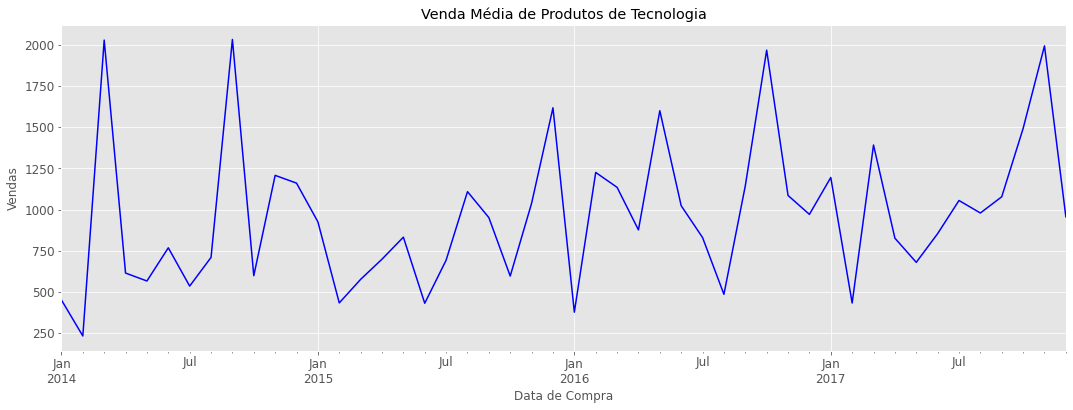

In [0]:
# Venda Média de Produtos de Tecnologia
media_vendas_tecnologia.plot(figsize = (18, 6), color = 'blue')
plt.xlabel("Data de Compra")
plt.ylabel('Vendas')
plt.title("Venda Média de Produtos de Tecnologia")
plt.show()

Agora, vamos decompor uma das séries para avaliar seus componentes.

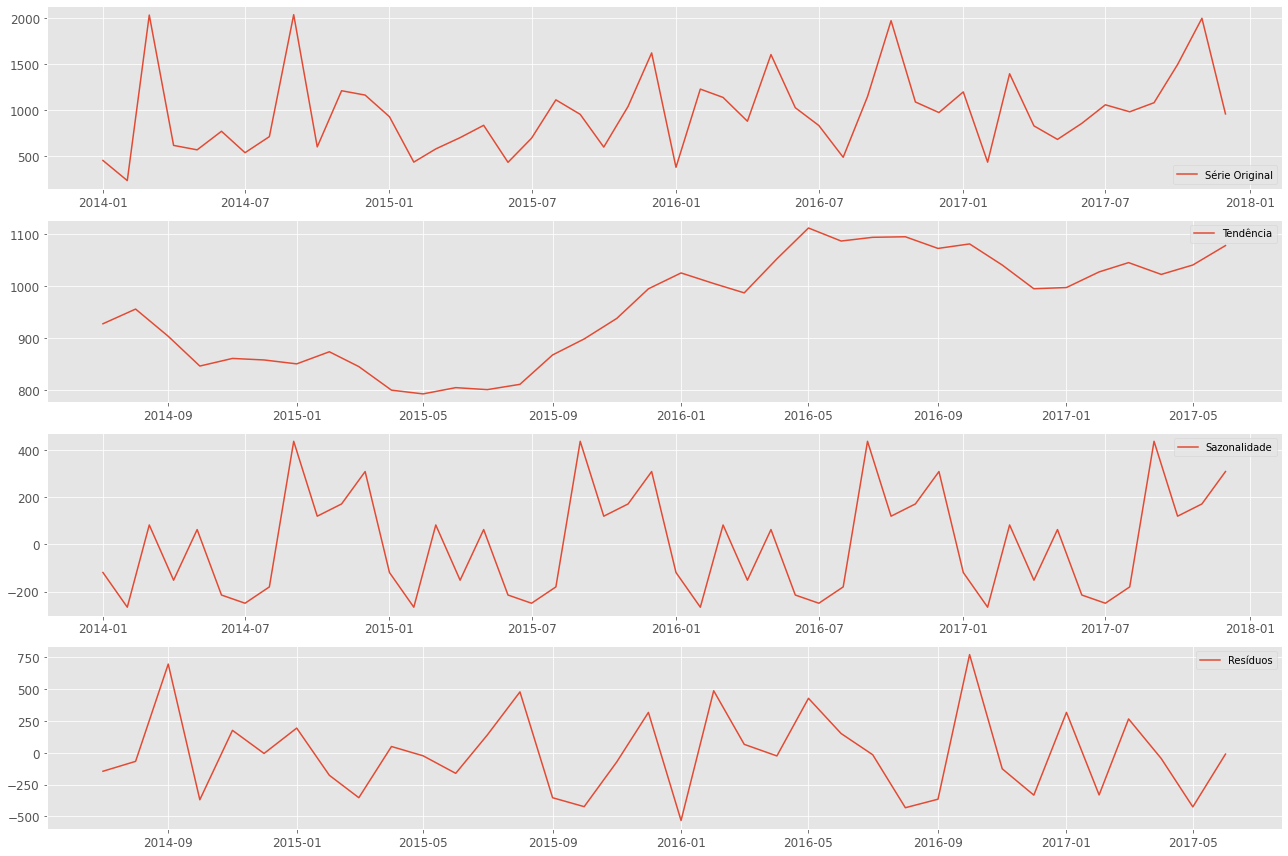

In [0]:
# Decomposição da série temporal de venda média de produtos de tecnologia
decomposition = seasonal_decompose(media_vendas_tecnologia, period = 12)
rcParams['figure.figsize'] = 18, 12

# Componentes
trend = decomposition.trend
seasonal = decomposition.seasonal
residual = decomposition.resid

# Plot
plt.subplot(411)
plt.plot(media_vendas_tecnologia, label = 'Série Original')
plt.legend(loc = 'best')
plt.subplot(412)
plt.plot(trend, label = 'Tendência')
plt.legend(loc = 'best')
plt.subplot(413)
plt.plot(seasonal, label = 'Sazonalidade')
plt.legend(loc = 'best')
plt.subplot(414)
plt.plot(residual, label = 'Resíduos')
plt.legend(loc = 'best')
plt.tight_layout()

Vamos testar a estacionaridade.

In [0]:
# Função para testar a estacionaridade
def testa_estacionaridade(serie):
    
    # Calcula estatísticas móveis
    rolmean = serie.rolling(window = 12).mean()
    rolstd = serie.rolling(window = 12).std()

    # Plot das estatísticas móveis
    plt.figure(figsize = (20, 6))
    orig = plt.plot(serie, color = 'blue', label = 'Original')
    mean = plt.plot(rolmean, color = 'red', label = 'Média Móvel')
    std = plt.plot(rolstd, color = 'black', label = 'Desvio Padrão')
    plt.legend(loc = 'best')
    plt.title('Estatísticas Móveis - Média e Desvio Padrão')
    plt.show()
    
    # Teste Dickey-Fuller:
    # Print
    print('\nResultado do Teste Dickey-Fuller:\n')

    # Teste
    dfteste = adfuller(serie, autolag = 'AIC')

    # Formatando a saída
    dfsaida = pd.Series(dfteste[0:4], index = ['Estatística do Teste',
                                               'Valor-p',
                                               'Número de Lags Consideradas',
                                               'Número de Observações Usadas'])

    # Loop por cada item da saída do teste
    for key, value in dfteste[4].items():
        dfsaida['Valor Crítico (%s)'%key] = value

    # Print
    print (dfsaida)
    
    # Testa o valor-p
    print ('\nConclusão:')
    if dfsaida[1] > 0.05:
        print('\nO valor-p é maior que 0.05 e, portanto, não temos evidências para rejeitar a hipótese nula.')
        print('Essa série provavelmente não é estacionária.')
    else:
        print('\nO valor-p é menor que 0.05 e, portanto, temos evidências para rejeitar a hipótese nula.')
        print('Essa série provavelmente é estacionária.')

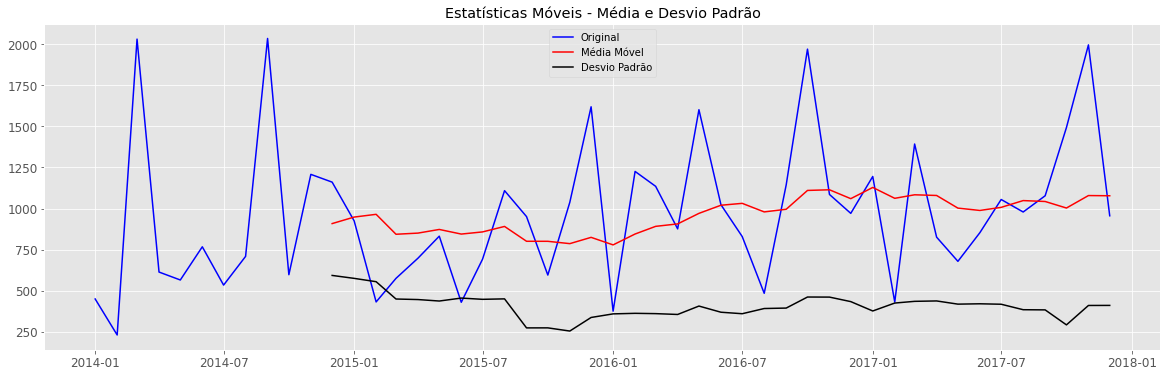


Resultado do Teste Dickey-Fuller:

Estatística do Teste           -7.187969e+00
Valor-p                         2.547334e-10
Número de Lags Consideradas     0.000000e+00
Número de Observações Usadas    4.700000e+01
Valor Crítico (1%)             -3.577848e+00
Valor Crítico (5%)             -2.925338e+00
Valor Crítico (10%)            -2.600774e+00
dtype: float64

Conclusão:

O valor-p é menor que 0.05 e, portanto, temos evidências para rejeitar a hipótese nula.
Essa série provavelmente é estacionária.


In [0]:
# Verifica se a série é estacionária
testa_estacionaridade(media_vendas_tecnologia)

### Dividindo os Dados em Treino e Teste

Para a preparação dos dados, vamos alternar entre objetos NumPy e Pandas, usando o que cada um oferece de melhor. Fique atento a cada passo.

In [0]:
# Série Original
X = media_vendas_tecnologia

In [0]:
# Os primeiros 36 registros da série serão usados como dados de treino
X[:-12]

order_date
2014-01-01     449.041429
2014-02-01     229.787143
2014-03-01    2031.948375
2014-04-01     613.028933
2014-05-01     564.698588
2014-06-01     766.905909
2014-07-01     533.608933
2014-08-01     708.435385
2014-09-01    2035.838133
2014-10-01     596.900900
2014-11-01    1208.056320
2014-12-01    1160.732889
2015-01-01     925.070800
2015-02-01     431.121250
2015-03-01     574.662333
2015-04-01     697.559500
2015-05-01     831.642857
2015-06-01     429.024400
2015-07-01     691.397733
2015-08-01    1108.902286
2015-09-01     950.856400
2015-10-01     594.716111
2015-11-01    1037.982652
2015-12-01    1619.637636
2016-01-01     374.671067
2016-02-01    1225.891400
2016-03-01    1135.150105
2016-04-01     875.911882
2016-05-01    1601.816167
2016-06-01    1023.259500
2016-07-01     829.312500
2016-08-01     483.620100
2016-09-01    1144.170300
2016-10-01    1970.835875
2016-11-01    1085.642360
2016-12-01     970.554870
Freq: MS, Name: sales, dtype: float64

In [0]:
# Os últimos 12 registros da série serão usados como dados de teste
X[-12:]

order_date
2017-01-01    1195.218071
2017-02-01     430.501714
2017-03-01    1392.859250
2017-04-01     825.559133
2017-05-01     678.329400
2017-06-01     853.055000
2017-07-01    1054.996636
2017-08-01     978.842333
2017-09-01    1077.704120
2017-10-01    1493.439227
2017-11-01    1996.750920
2017-12-01     955.865652
Freq: MS, Name: sales, dtype: float64

In [0]:
# Divisão em treino e teste
treino, teste = np.array(X[:-12]), np.array(X[-12:])

In [0]:
# Ajusta o shape, pois agora não temos um objeto pd.Series, 
# mas sim um array NumPy, que é necessário para treinar o modelo LSTM
trainset = treino.reshape(-1,1)
testset = teste.reshape(-1,1)

In [0]:
len(trainset)

36

In [0]:
trainset

array([[ 449.04142857],
       [ 229.78714286],
       [2031.948375  ],
       [ 613.02893333],
       [ 564.69858824],
       [ 766.90590909],
       [ 533.60893333],
       [ 708.43538462],
       [2035.83813333],
       [ 596.9009    ],
       [1208.05632   ],
       [1160.73288889],
       [ 925.0708    ],
       [ 431.12125   ],
       [ 574.66233333],
       [ 697.5595    ],
       [ 831.64285714],
       [ 429.0244    ],
       [ 691.39773333],
       [1108.90228571],
       [ 950.8564    ],
       [ 594.71611111],
       [1037.98265217],
       [1619.63763636],
       [ 374.67106667],
       [1225.8914    ],
       [1135.15010526],
       [ 875.91188235],
       [1601.81616667],
       [1023.2595    ],
       [ 829.3125    ],
       [ 483.6201    ],
       [1144.1703    ],
       [1970.835875  ],
       [1085.64236   ],
       [ 970.55486957]])

In [0]:
len(testset)

12

In [0]:
testset

array([[1195.21807143],
       [ 430.50171429],
       [1392.85925   ],
       [ 825.55913333],
       [ 678.3294    ],
       [ 853.055     ],
       [1054.99663636],
       [ 978.84233333],
       [1077.70412   ],
       [1493.43922727],
       [1996.75092   ],
       [ 955.86565217]])

### Função Para o Cálculo da Acurácia

In [0]:
# Função
def performance(y_true, y_pred): 
    mse = ((y_pred - y_true) ** 2).mean()
    mape = np.mean(np.abs((y_true - y_pred) / y_true)) * 100
    return( print('MSE das previsões é {}'.format(round(mse, 2))+
                  '\nRMSE das previsões é {}'.format(round(np.sqrt(mse), 2))+
                  '\nMAPE das previsões é {}'.format(round(mape, 2))))

Acesse o <a href="http://datascienceacademy.com.br/blog/">Blog da DSA</a> e fique por dentro das novidades em Data Science, Big Data, IA, RPA, Blockchain e mercado de trabalho.

## Modelo Stacked LSTM

A rede Long Short-Term Memory, ou LSTM, é uma rede neural recorrente treinada usando Backpropagation Through Time e supera o problema da dissipação do gradiente (isso é explicado no Deep Learning Book).

Como tal, o modelo pode ser usado para criar grandes redes recorrentes que, por sua vez, podem ser usadas para resolver problemas de sequência difíceis no aprendizado de máquina e obter resultados de última geração.

Podemos alterar a arquitetura do modelo e adicionar mais uma camada LSTM, aumentando assim a capacidade de previsão do modelo.

Esse modelo é estudado em detalhes no curso <a href="https://www.datascienceacademy.com.br/course?courseid=deep-learning-ii">Deep Learning II</a>.

### Como Escolher o Número de Camadas e Neurônios em Uma Rede Neural Artificial?

Toda Rede Neural Artificial tem três tipos de camadas: entrada, oculta e saída.

Portanto, criar a arquitetura da rede significa criar valores para o número de camadas de cada tipo e o número de nós em cada uma dessas camadas.

**A Camada de Entrada**

Toda rede neural, sem exceção, deve ter uma camada de entrada, aquela que recebe os dados.

Com relação ao número de neurônios que compõem essa camada, esse parâmetro é determinado de maneira completa e exclusiva quando você conhece o formato dos dados de treinamento. Especificamente, o número de neurônios que compõem essa camada é igual ao número de recursos (colunas) em seus dados. Algumas configurações de redes neurais adicionam um nó adicional para um termo de polarização (bias).

**A Camada de Saída**

Como a camada de entrada, toda rede neural tem exatamente uma camada de saída. Determinar seu tamanho (número de neurônios) é simples; é completamente determinado pela configuração do modelo escolhido.

Estamos trabalhando em um problema de regressão ou classificação?

Se a rede neural for um regressor, a camada de saída terá um único nó para retornar um valor numérico.

Se a rede neural for um classificador, ela também terá um único nó, a menos que o softmax seja usado. Nesse caso, a camada de saída possui um nó por rótulo de classe no seu modelo, que em geral entrega uma probabilidade para cada classe.

**As Camadas Ocultas**

Definir as camadas de entrada e saída é fácil, pois elas estão associadas aos dados que alimentamos na rede e ao que vamos obter como saída, respectivamente. Resta então as camadas ocultas.

Quantas camadas ocultas? Bem, se seus dados são linearmente separáveis (que você já sabe quando começa a codificar uma rede neural), não precisa de nenhuma camada oculta. 

Existe um consenso sobre a diferença de desempenho da inclusão de camadas ocultas adicionais: as situações em que o desempenho melhora com uma segunda (ou terceira, etc.) camada oculta são muito poucas. Uma camada oculta é suficiente para a grande maioria dos problemas.

E quanto ao tamanho da (s) camada (s) oculta (s) - quantos neurônios? Existem algumas regras práticas derivadas empiricamente, dentre as quais a mais comum é a de que "o tamanho ideal da camada oculta geralmente está entre o tamanho da entrada e o tamanho das camadas de saída". 

**Boas Práticas**

Em suma, para a maioria dos problemas, é possível obter um desempenho decente (mesmo sem uma segunda etapa de otimização) definindo a configuração da camada oculta usando apenas duas regras: (i) o número de camadas ocultas é igual a um; e (ii) o número de neurônios nessa camada é a média dos neurônios nas camadas de entrada e saída.

Portanto, há realmente duas decisões que devem ser tomadas com relação às camadas ocultas: quantas camadas ocultas devem realmente existir na rede neural e quantos neurônios estarão em cada uma dessas camadas. 

Problemas que requerem duas camadas ocultas raramente são encontrados. No entanto, redes neurais com duas camadas ocultas podem representar funções com qualquer tipo de forma. Atualmente, não há razão teórica para usar redes neurais com mais de duas camadas ocultas. De fato, para muitos problemas práticos, não há razão para usar mais de uma camada oculta. Assim, o useo de muitas camadas ocultas pode tornar o treinamento muito mais lento e oferecer quase nada em termos de performance da rede. Mesmo modelos avançados de Deep Learning (com muitas camadas ocultas) são problemas e dados bem específicos.

Decidir o número de neurônios nas camadas ocultas é uma parte muito importante para decidir sua arquitetura geral da rede neural. Embora essas camadas não interajam diretamente com o ambiente externo, elas exercem uma tremenda influência sobre o resultado final. Tanto o número de camadas ocultas quanto o número de neurônios em cada uma dessas camadas ocultas devem ser cuidadosamente considerados.

Usar poucos neurônios nas camadas ocultas resultará em algo chamado desajustamento. A falta de ajuste ocorre quando há  poucos neurônios nas camadas ocultas para detectar adequadamente os sinais em um conjunto de dados complicado.

O uso de muitos neurônios nas camadas ocultas pode resultar em vários problemas. Primeiro, muitos neurônios nas camadas ocultas podem resultar em sobreajuste (overfitting). O sobreajuste ocorre quando a rede neural tem tanta capacidade de processamento de informações que a quantidade limitada de informações contidas no conjunto de treinamento não é suficiente para treinar todos os neurônios nas camadas ocultas. Um segundo problema pode ocorrer mesmo quando os dados de treinamento são suficientes. Um número excessivamente grande de neurônios nas camadas ocultas pode aumentar o tempo necessário para treinar a rede. A quantidade de tempo de treinamento pode aumentar a ponto de ser impossível treinar adequadamente a rede neural. 

Existem muitos métodos práticos para determinar o número correto de neurônios a serem usados nas camadas ocultas, como os seguintes:

- O número de neurônios ocultos deve estar entre o tamanho da camada de entrada e o tamanho da camada de saída.
- O número de neurônios ocultos deve ser 2/3 do tamanho da camada de entrada, mais o tamanho da camada de saída.
- O número de neurônios ocultos deve ser menor que o dobro do tamanho da camada de entrada.

Mas na prática, o ideal é a experimentação e testar diferentes combinações do número de camadas e neurônios.

### Preparando os Dados Para Treinamento

Como regra geral, sempre que você usa uma rede neural, você deve normalizar ou dimensionar seus dados. Usaremos a classe MinMaxScaler da biblioteca sklearn.preprocessing para dimensionar nossos dados entre 0 e 1. O parâmetro feature_range é usado para especificar o intervalo dos dados dimensionados e se não for especificado o intevalo será entre 0 e 1.

In [0]:
# Cria o scaler
scaler = MinMaxScaler()

In [0]:
# Treina o scaler nos dados de treino (nunca no dataset completo ou nos dados de teste)
scaler.fit(trainset)

MinMaxScaler(copy=True, feature_range=(0, 1))

In [0]:
# Aplica o mesmo scaler aos dados de treino 
# (Não precisamos aplicar aos dados de teste, pois vamos converter a saída das previsões antes de avaliar o modelo)
trainset = scaler.transform(trainset)

In [0]:
trainset.shape

(36, 1)

In [0]:
trainset

array([[0.12139983],
       [0.        ],
       [0.99784626],
       [0.21219877],
       [0.18543853],
       [0.29739956],
       [0.16822437],
       [0.26502477],
       [1.        ],
       [0.20326877],
       [0.54166199],
       [0.51545928],
       [0.38497454],
       [0.11147753],
       [0.1909554 ],
       [0.25900285],
       [0.33324403],
       [0.11031652],
       [0.25559112],
       [0.48676098],
       [0.39925188],
       [0.20205906],
       [0.44749318],
       [0.76955219],
       [0.08022139],
       [0.55153717],
       [0.50129424],
       [0.35775554],
       [0.75968454],
       [0.43934106],
       [0.33195373],
       [0.14054584],
       [0.50628867],
       [0.96400863],
       [0.47388209],
       [0.41015881]])

Aqui definimos os hiperparâmetros.

In [0]:
# Número de repetições
n_rep = 20

# Número de epochs
num_epochs = 200

# Número de inputs (usaremos 12 séries para prever as 12 séries seguintes)
n_input = 12

# Comprimento das sequências de saída (em número de timesteps)
n_output = 12

# Aqui estamos indicando que nossa série é univariada, logo, apenas 1 recurso
n_features = 1

# Número de amostras de séries temporais em cada lote
size_batch = 10

O TimeseriesGenerator do Keras transforma automaticamente um conjunto de dados univariado de séries temporais em um dataset para problema de aprendizado supervisionado.

https://keras.io/preprocessing/sequence/

In [0]:
# Generator
generator = TimeseriesGenerator(trainset, 
                                trainset, 
                                length = n_output,
                                batch_size = size_batch)

Podemos agora criar o modelo Stacked LSTM.

Detalhes sobre os hiperparâmetros aqui:

https://keras.io/layers/recurrent/

In [0]:
# Criação e treinamento do modelo LSTM Padrão

# Criamos uma matriz preenchida com zeros que receberá o resultado das previsões do nosso modelo
resultado = np.zeros((n_input, n_rep))

# Loop
# Vamos repetir o processo de treinamento por 20 vezes e armazenar todos os resultados, pois assim usaremos
# diferentes amostras. Ao final, tiramos a média para encontrar as previsões.
for i in range(n_rep):
    
    # O primeiro passo é criar o modelo, ou seja, um objeto da classe Sequential() do Keras
    modelo_lstm = Sequential()
    
    # Podemos adicionar agora a primeira camada da rede, ou camada de entrada.
    # Esta é a camada que recebe os dados.
    # Como vamos criar uma arquitetura de camadas LSTM em pilha, precisamos adicionar o parâmetro:
    # return_sequences = True, indicando que esta camada deve retornar uma sequência que será usada
    # como entrada na próxima camada LSTM
    modelo_lstm.add(LSTM(40, activation = 'tanh', return_sequences = True, input_shape = (n_input, n_features)))
    
    # Mais uma camada LSTM
    modelo_lstm.add(LSTM(40, activation = 'relu'))
    
    # Adicionamos a primeira camada intermediária ou oculta
    modelo_lstm.add(Dense(50, activation = 'relu'))
    
    # Adicionamos a segunda camada intermediária ou oculta
    modelo_lstm.add(Dense(50, activation = 'relu'))
    
    # Adicionamos a camada de saída e tudo que precisamos é de 1 neurônio pois estamos prevendo apenas 1 valor.
    modelo_lstm.add(Dense(1))
    
    # Com as camadas prontas, podemos definir a função de perda, nesse caso usaremos o MSE (Mean Squared Error)
    # E indicamos o algoritmo de otimização (minimização da função de perda), em nosso caso ADAM
    adam = optimizers.Adam(learning_rate = 0.001)
    modelo_lstm.compile(optimizer = adam, loss = 'mean_squared_error')
    
    # Aqui fazemos o treinamento gerando batches de dados
    modelo_lstm.fit_generator(generator, epochs = num_epochs)
    
    # Lista para as previsões
    pred_list = []

    # Gera um batch de dados
    batch = trainset[-n_input:].reshape((1, n_input, n_features))

    # Loop para fazer as previsões
    for j in range(n_input):   
        pred_list.append(modelo_lstm.predict(batch)[0]) 
        batch = np.append(batch[:,1:,:], [[pred_list[j]]], axis = 1)

    # Gera o dataframe com as previsões
    df_predict_modelo_lstm = pd.DataFrame(scaler.inverse_transform(pred_list),
                                      index = X[-n_input:].index, columns = ['Prediction'])

    resultado[:,i] = df_predict_modelo_lstm['Prediction']
    
print(resultado)

Streaming output truncated to the last 5000 lines.
3/3 [==============================] - 0s 70ms/step - loss: 0.0512
Epoch 126/200
3/3 [==============================] - 0s 80ms/step - loss: 0.0515
Epoch 127/200
3/3 [==============================] - 0s 69ms/step - loss: 0.0511
Epoch 128/200
3/3 [==============================] - 0s 75ms/step - loss: 0.0507
Epoch 129/200
3/3 [==============================] - 0s 68ms/step - loss: 0.0523
Epoch 130/200
3/3 [==============================] - 0s 70ms/step - loss: 0.0517
Epoch 131/200
3/3 [==============================] - 0s 76ms/step - loss: 0.0516
Epoch 132/200
3/3 [==============================] - 0s 71ms/step - loss: 0.0513
Epoch 133/200
3/3 [==============================] - 0s 76ms/step - loss: 0.0516
Epoch 134/200
3/3 [==============================] - 0s 69ms/step - loss: 0.0512
Epoch 135/200
3/3 [==============================] - 0s 70ms/step - loss: 0.0508
Epoch 136/200
3/3 [==============================] - 0s 69ms/step - loss

O mais delicado na criação do modelo é definir o input_shape da primeira camada. É isso que o modelo espera como entrada para cada amostra em termos do número de etapas de tempo e do número de recursos.

Estamos trabalhando com uma série univariada, portanto, o número de recursos é um, para uma variável.

O número de etapas de tempo como entrada é o número que escolhemos para prever as sequências de saída. Em nosso exemplo, estamos usando 12 sequências para prever 12 sequências.

Quase sempre temos várias amostras; portanto, o modelo espera que o componente de entrada dos dados de treinamento tenha as dimensões ou a forma:

[samples, timesteps, features]

Em nosso exemplo, nós temos:

- samples = n_rep (20)
- timesteps = n_input (12)
- features = n_features (1)

Agora calculamos o erro modelo.

In [0]:
# Vamos criar uma matriz com as mesmas dimensões da matriz de resultado usada no treinamento
resultado_final = np.zeros((resultado.shape[0],1))

In [0]:
# Loop para gerar as previsões finais
for i in range(resultado.shape[0]):
    resultado_final[i] = np.mean(resultado[i,:])

In [0]:
# Previsões finais
resultado_final

array([[1095.44934528],
       [1138.09984162],
       [1138.14896187],
       [1141.46120404],
       [1153.20982247],
       [1138.96887608],
       [1147.67852208],
       [1157.95395011],
       [1185.4655134 ],
       [1181.22922005],
       [1150.76898842],
       [1157.05648016]])

In [0]:
# Ajustamos o shape
resultado_final = resultado_final.reshape((12,))

In [0]:
# Previsões finais
resultado_final

array([1095.44934528, 1138.09984162, 1138.14896187, 1141.46120404,
       1153.20982247, 1138.96887608, 1147.67852208, 1157.95395011,
       1185.4655134 , 1181.22922005, 1150.76898842, 1157.05648016])

In [0]:
# Calculamos e imprimos a performance do modelo
modelo_lstm_performance = performance(testset, resultado_final)
modelo_lstm_performance

MSE das previsões é 159542.17
RMSE das previsões é 399.43
MAPE das previsões é 37.5


Conseguimos reduzir o RMSE, mas aumentamos o MAPE.

Não é fácil ajustar um modelo de previsão de série temporal. De fato, trouxemos uma série difícil mesmo (média mensal de vendas) para demonstrar as complicações envolvidas em todo o processo.

Estamos procurando fazer poucas mudanças de uma aula para outra, para ajudar você a comparar os modelos. Mas fique à vontade para mudar os hiperparâmetros e tentar chegar ao melhor modelo.

Vamos continuar em busca do modelo ideal para prever nossas vendas. Ainda tenho algumas cartas na manga. Como é mesmo que se diz? Ahh...sim: "quanto mais ferramentas você sabe, mais problemas é capaz de resolver".

Abaixo o plot das previsões.

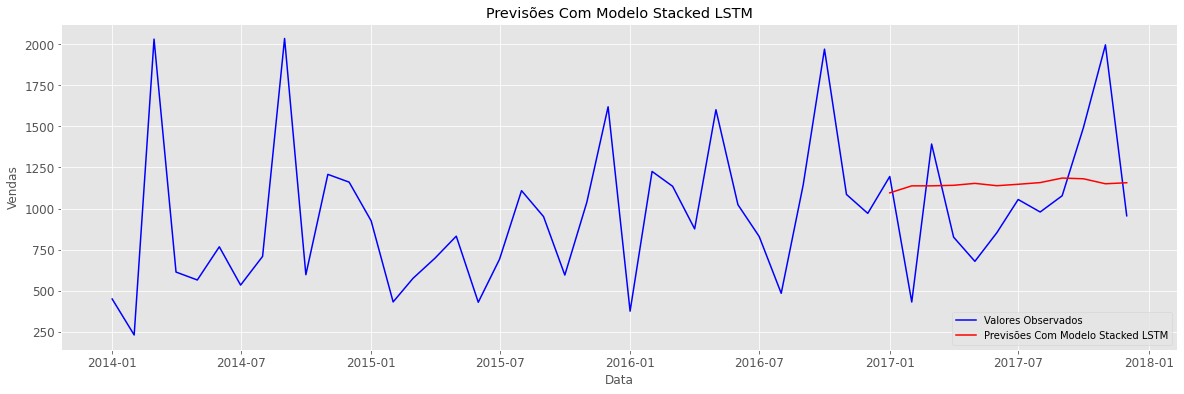

In [0]:
# Plot
plt.figure(figsize = (20, 6))

# Série original
plt.plot(media_vendas_tecnologia.index, 
         media_vendas_tecnologia.values,
         label = 'Valores Observados',
         color = 'Blue')

# Previsões
plt.plot(media_vendas_tecnologia[36:].index, 
         resultado_final,
         label = 'Previsões Com Modelo Stacked LSTM', 
         color = 'Red')

plt.title('Previsões Com Modelo Stacked LSTM')
plt.xlabel('Data')
plt.ylabel('Vendas')
plt.legend()
plt.show()

Vamos fazer o Forecasting para 12 meses de horizonte de previsão. A função DateOffset() vai nos ajudar a criar as datas.

Vejamos qual é a última data da nossa série original:

In [0]:
# Última data da série
media_vendas_tecnologia.index[-1]

Timestamp('2017-12-01 00:00:00', freq='MS')

In [0]:
# Cria sequência de datas a partir da última data da nossa série original
datas_para_prever_forecasting = [media_vendas_tecnologia.index[-1] + DateOffset(months = x) for x in range(0, 13)]

In [0]:
# Visualiza as datas criadas
datas_para_prever_forecasting

[Timestamp('2017-12-01 00:00:00'),
 Timestamp('2018-01-01 00:00:00'),
 Timestamp('2018-02-01 00:00:00'),
 Timestamp('2018-03-01 00:00:00'),
 Timestamp('2018-04-01 00:00:00'),
 Timestamp('2018-05-01 00:00:00'),
 Timestamp('2018-06-01 00:00:00'),
 Timestamp('2018-07-01 00:00:00'),
 Timestamp('2018-08-01 00:00:00'),
 Timestamp('2018-09-01 00:00:00'),
 Timestamp('2018-10-01 00:00:00'),
 Timestamp('2018-11-01 00:00:00'),
 Timestamp('2018-12-01 00:00:00')]

In [0]:
# Nossa série original é um objeto do tipo pd.Series
type(media_vendas_tecnologia)

pandas.core.series.Series

In [0]:
# Objetos do tipo pd.Series dão mais trabalho para manipular. Vamos converter a série original em dataframe.
df_original = pd.DataFrame(media_vendas_tecnologia)

In [0]:
# Visualiza os dados
df_original.head()

,sales
order_date,
2014-01-01,449.041429
2014-02-01,229.787143
2014-03-01,2031.948375
2014-04-01,613.028933
2014-05-01,564.698588


In [0]:
# Vamos agora criar um novo dataframe 
# O índice (data) será a sequência de datas futuras
# O nome da coluna de dados extraímos da série original
# ATENÇÃO: Não estamos extraindo os dados da série original, somente o nome da coluna
data_futuras = pd.DataFrame(index = datas_para_prever_forecasting[1:], columns = df_original.columns)

In [0]:
# Visualiza os dados
# Entendeu por que os valores NaN? São datas futuras, e precisamos agora incluir nossas previsões.
data_futuras

,sales
2018-01-01,NaN
2018-02-01,NaN
2018-03-01,NaN
2018-04-01,NaN
2018-05-01,NaN
2018-06-01,NaN
2018-07-01,NaN
2018-08-01,NaN
2018-09-01,NaN
2018-10-01,NaN


In [0]:
# Usamos as datas futuras para extrair as previsões do nosso modelo
df_predict = pd.DataFrame(scaler.inverse_transform(pred_list),
                          index = data_futuras[-n_input:].index, columns = ['Prediction'])

In [0]:
# Concatenamos a série original com os valores de forecasting de 12 meses além da série
df_forecasting = pd.concat([df_original, df_predict], axis = 1)

In [0]:
# Visualiza o dataframe
df_forecasting

,sales,Prediction
2014-01-01,449.041429,NaN
2014-02-01,229.787143,NaN
2014-03-01,2031.948375,NaN
2014-04-01,613.028933,NaN
2014-05-01,564.698588,NaN
2014-06-01,766.905909,NaN
2014-07-01,533.608933,NaN
2014-08-01,708.435385,NaN
2014-09-01,2035.838133,NaN
2014-10-01,596.900900,NaN


### Previsão x Forecasting

Esse dataframe acima é para não restar qualquer dúvida do que estamos fazendo.

Nas **previsões** do modelo, usamos os dados de teste, 12 meses que correspondem aos 12 últimos registros da série original (2017-01-01 a 2017-12-01. Fazemos isso para poder calcular a precisão do modelo, comparando as previsões com os valores reais. Esse é o padrão em Machine Learning.

No **forecasting**, criamos 12 meses após a última data da série original. Obviamente, não temos dados históricos para esses meses e o que queremos é exatamente a previsão de vendas. O forecasting significa usar o modelo treinado e prever valores sobre novas datas.

Bingo!

Vamos colocar o forecasting em um Plot.

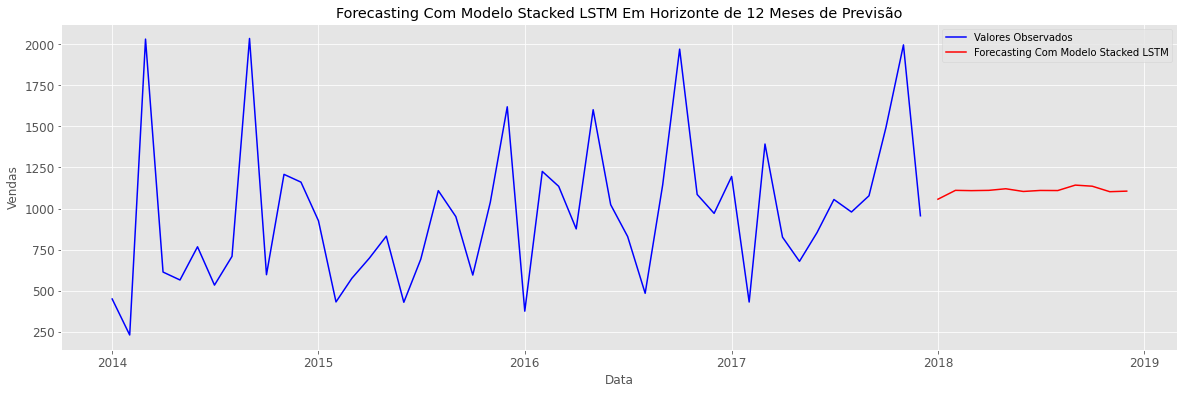

In [0]:
# Plot
plt.figure(figsize = (20, 6))

# Série original
plt.plot(df_forecasting.index, 
         df_forecasting['sales'],
         label = 'Valores Observados',
         color = 'Blue')

# Previsões
plt.plot(df_forecasting.index, 
         df_forecasting['Prediction'],
         label = 'Forecasting Com Modelo Stacked LSTM', 
         color = 'Red')

plt.title('Forecasting Com Modelo Stacked LSTM Em Horizonte de 12 Meses de Previsão')
plt.xlabel('Data')
plt.ylabel('Vendas')
plt.legend()
plt.show()

E aí está nosso primeiro modelo de Deep Learning para previsão de séries temporais!

Como estamos até agora:
    
- Aula 15 --> Modelo ARMA(1,1) - AIC = 550.3, RMSE = 420.2 e MAPE = 29.58
- Aula 16 --> Modelo ARIMA(6,0,2) - AIC = 559.4, RMSE = 401.5 e MAPE = 26.58
- Aula 17 --> Modelo SARIMA(0, 0, 0)x(0, 1, 1, 12) - AIC = 176.74, RMSE = 425.89 e MAPE = 34.95
- Aula 18 --> Modelo SARIMA(1, 1, 0)x(1, 1, 0, 12) - AIC = 146.77, RMSE = 353.57 e MAPE = 30.55
- Aula 19 --> Modelo SARIMA(1, 1, 0)x(1, 1, 0, 12) com exog  - AIC = 149.66, RMSE = 341.23 e MAPE = 32.54
- Aula 20 --> Modelo Prophet 1 - RMSE = 347.58 e MAPE = 28.53
- Aula 21 --> Modelo Prophet 2 - RMSE = 325.52 e MAPE = 26.45
- Aula 22 --> Modelo LSTM Padrão - RMSE = 397.12 e MAPE = 31.46
- Aula 23 --> Modelo Stacked LSTM - RMSE = 396.24 e MAPE = 36.35

Vamos seguir otimizando nossa rede LSTM e ver até onde conseguimos ir com essa arquitetura.

# Fim